In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
from torch import nn, optim

In [3]:
model = scipy.io.loadmat('data21.mat')

In [4]:
class Generator(nn.Module): #Fully connected network
    def __init__(self): 
        super(Generator, self).__init__()
        self.inLayer = nn.Linear(10, 128) #input layer of specified input size
        self.outLayer = nn.Linear(128, 784) #output layer

    def forward(self, x): #forward method
        x = self.inLayer(x) #feed input through the input layer
        x = torch.relu(x)
        x = self.outLayer(x)
        x = torch.sigmoid(-x) #sigmoidal activation

        return x

In [5]:
def initialize_generator(G):
    state_dict = G.state_dict() #state dict contains current network parameters per layer
    
    #pass pretrained network parameters to our generators parameters
    state_dict['inLayer.weight'] = torch.tensor(model['A_1'])
    state_dict['inLayer.bias'] = torch.tensor(model['B_1'].flatten())
    state_dict['outLayer.weight'] = torch.tensor(model['A_2'])
    state_dict['outLayer.bias'] = torch.tensor(model['B_2'].flatten())
    
    G.load_state_dict(state_dict) #update state dict 
    return G

In [6]:
def output_to_image(y):
    return y.detach().numpy().reshape(28,28).T #covert from tensor to numpy array, from 784x1 to 28x28 and transpose to flip

In [7]:
G = initialize_generator(Generator()).double()

In [8]:
#create 
images = np.concatenate([np.concatenate([output_to_image(G(torch.tensor(np.random.normal(0,1,10)).double())) for i in range(10)], axis=1) for i in range(10)])

(-0.5, 279.5, 279.5, -0.5)

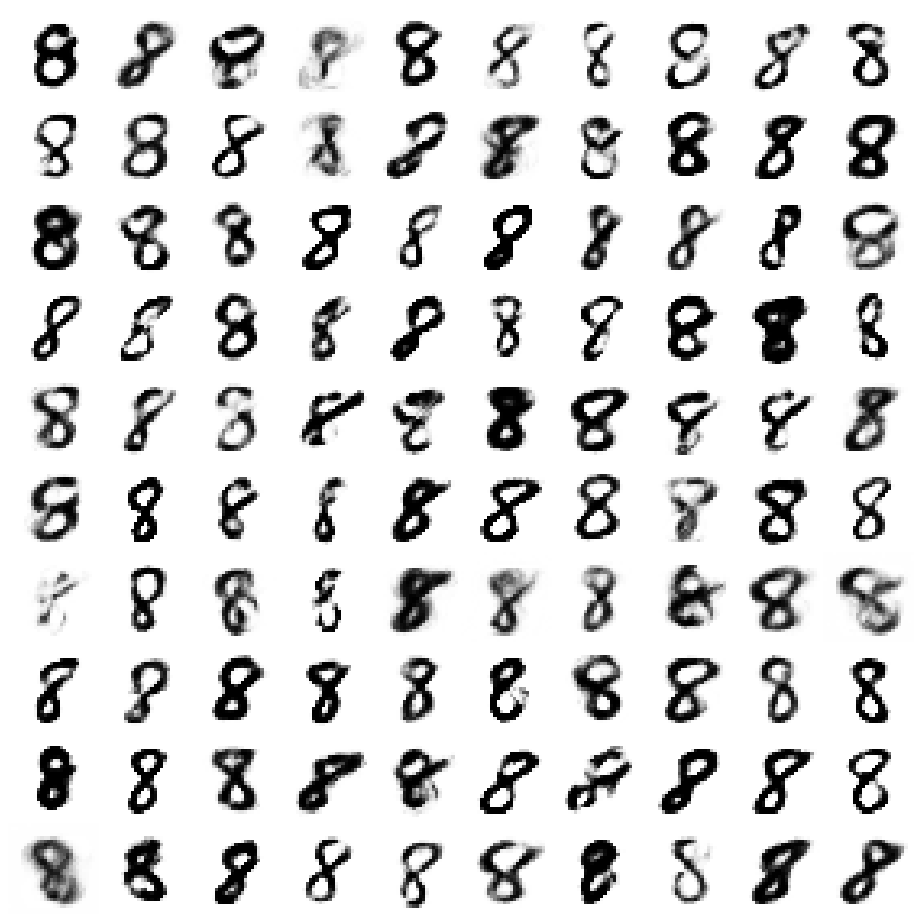

In [9]:
plt.figure(figsize=(15, 15), dpi=80)
plt.imshow(images,cmap='gray')
plt.axis('off')

$Ασκηση 2.2$

In [15]:
impainting_data = scipy.io.loadmat('data22.mat')
clean_images = impainting_data['X_i']
noisy_images = impainting_data['X_n']
impainted_images = np.copy(noisy_images)
impainted_images[28*15:]=0

(-0.5, 111.5, 27.5, -0.5)

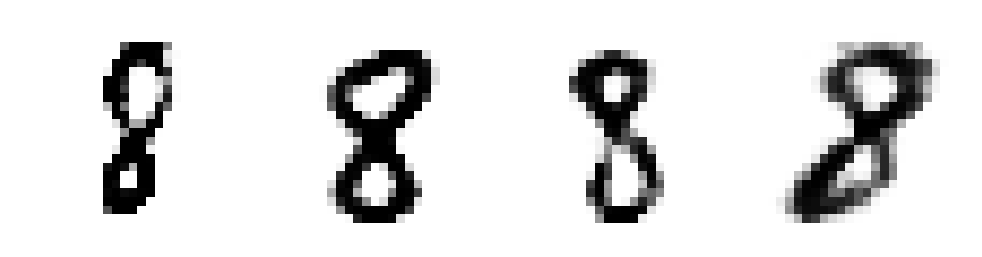

In [12]:
plt.figure(figsize=(16, 4), dpi=80)
plt.imshow(np.concatenate([i.reshape(28,28).T for i in clean_images.T],axis=1), cmap='gray')
plt.axis('off')

(-0.5, 111.5, 27.5, -0.5)

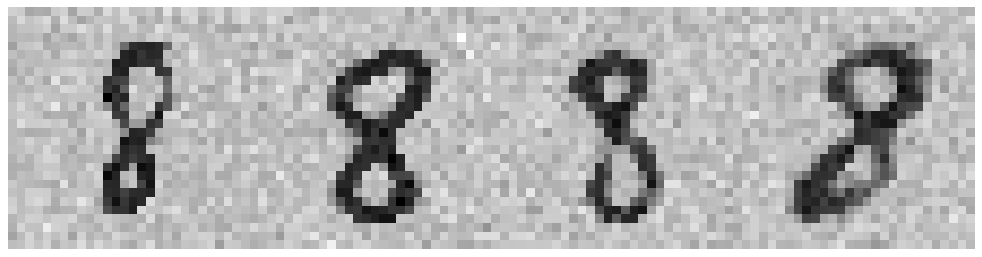

In [13]:
plt.figure(figsize=(16, 4), dpi=80)
plt.imshow(np.concatenate([i.reshape(28,28).T for i in noisy_images.T],axis=1), cmap='gray')
plt.axis('off')

(-0.5, 111.5, 27.5, -0.5)

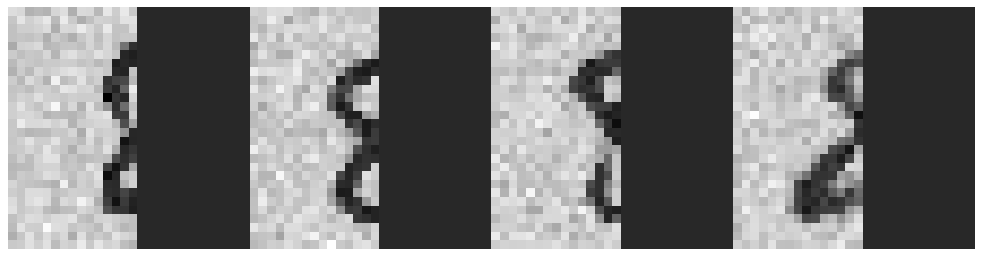

In [16]:
plt.figure(figsize=(16, 4), dpi=80)
plt.imshow(np.concatenate([i.reshape(28,28).T for i in impainted_images.T],axis=1), cmap='gray')
plt.axis('off')

In [17]:
I = np.identity(28*15)
O = np.zeros((28*15,784-28*15))
T = np.concatenate([I,O],axis=1)

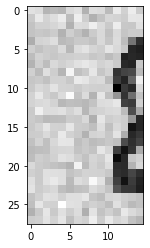

In [18]:
plt.imshow((T@noisy_images[:,0]).reshape(-1,28).T, cmap='gray')

In [22]:
noises = []
for i in range(4):
    
    init_z = torch.tensor(np.random.normal(0,1,10)) #input as tensor
    init_z.requires_grad = True #track z operation to build the computation graph for future differentiation
    optimizer = torch.optim.Adam([init_z] ,lr=5e-2) #define optimizer
    print(f'-----image:{i}-----')
    
    M = 28*15
    Xn = torch.tensor(T@noisy_images[:,i])
        
    for epoch in range(500):
        loss = M*torch.log(torch.sum((torch.matmul(torch.tensor(T),G(init_z))-Xn)**2)) + torch.sum((init_z**2))

        optimizer.zero_grad()#clear previously stored gradients
        loss.backward() #calculates loss gradients wrt NN parameters
        optimizer.step() #apply an adam step
        if epoch%100 == 0:
            print(f'epoch:{epoch+1}, loss:{loss.item()}')
    noises.append(init_z)
    print('------------------- \n')    

-----image:0-----
epoch:1, loss:1485.4945469265222
epoch:101, loss:587.3766493068023
epoch:201, loss:579.5355050392185
epoch:301, loss:567.8264055877303
epoch:401, loss:567.7349474448731
------------------- 

-----image:1-----
epoch:1, loss:1565.5036774211226
epoch:101, loss:725.8515465531536
epoch:201, loss:578.0660550030818
epoch:301, loss:578.0475875670943
epoch:401, loss:578.047586917461
------------------- 

-----image:2-----
epoch:1, loss:1751.4346603766166
epoch:101, loss:627.3949013188596
epoch:201, loss:597.1381823861026
epoch:301, loss:597.1324991679774
epoch:401, loss:597.1325606228379
------------------- 

-----image:3-----
epoch:1, loss:1594.7712377529808
epoch:101, loss:550.1883164595966
epoch:201, loss:549.6931967678787
epoch:301, loss:549.6931895069835
epoch:401, loss:549.693189506653
------------------- 



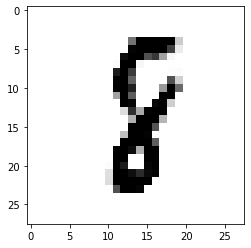

In [23]:
plt.imshow(output_to_image(G(noises[0])),cmap='gray')

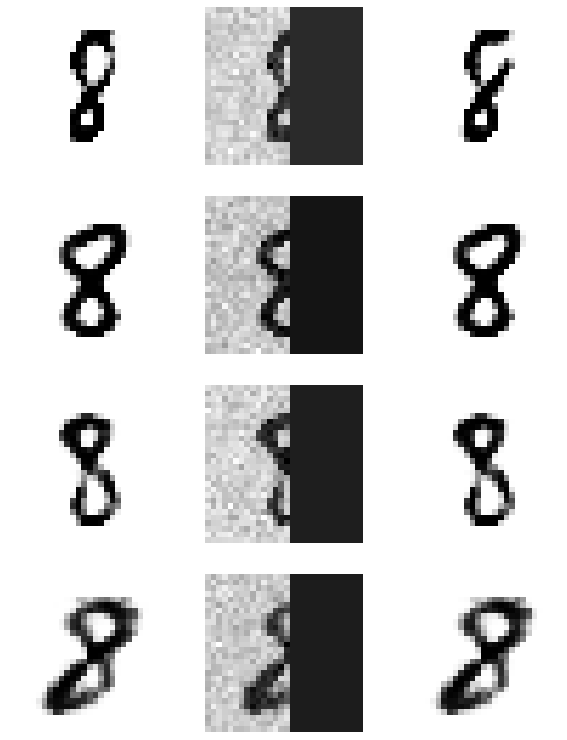

In [24]:
plt.figure(figsize=(9,12), dpi=80) #figure size

for i in range(4):
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
    #images = np.concatenate([clean_images[:,i].reshape(28,28).T,impainted_images[:,i].reshape(28,28).T, output_to_image(G(noises[i]))],axis=1)
    #plt.imshow(images,cmap='gray', vmax=images.max())
    #ax1.imshow(clean_images[:,i].reshape(28,28).T,cmap='gray')
    #ax2.imshow(impainted_images[:,i].reshape(28,28).T,cmap='gray')
    #ax3.imshow(output_to_image(G(noises[i])),cmap='gray')
    
    plt.subplot(4, 3, 1+3*i)
    plt.imshow(clean_images[:,i].reshape(28,28).T,cmap='gray')
    plt.axis('off')
    plt.subplot(4, 3, 2+3*i)
    plt.imshow(impainted_images[:,i].reshape(28,28).T,cmap='gray')
    plt.axis('off')
    plt.subplot(4, 3, 3+3*i)
    plt.imshow(output_to_image(G(noises[i])),cmap='gray')
    plt.axis('off')

    #plt.show()

$Ακσηση 2.3$

In [25]:
super_resolution_data = scipy.io.loadmat('data23.mat')
clean_images = super_resolution_data['X_i']
noisy_images = super_resolution_data['X_n']

(-0.5, 111.5, 27.5, -0.5)

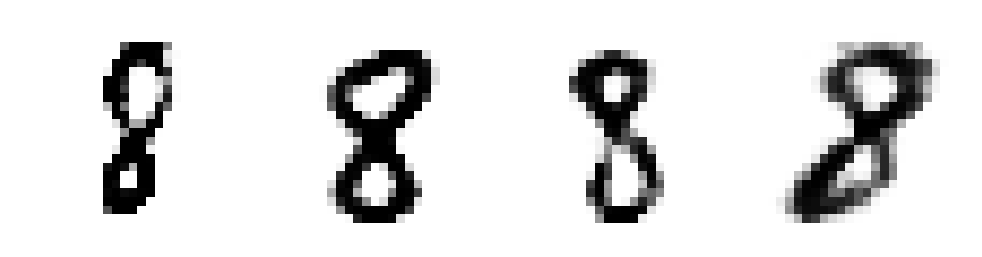

In [26]:
plt.figure(figsize=(16, 4), dpi=80)
plt.imshow(np.concatenate([i.reshape(28,28).T for i in clean_images.T],axis=1), cmap='gray')
plt.axis('off')

(-0.5, 27.5, 6.5, -0.5)

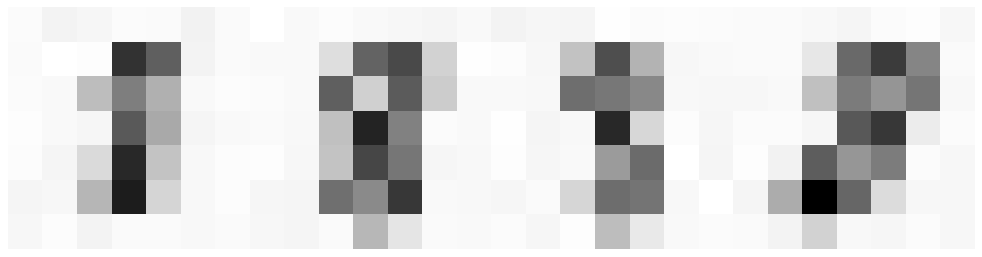

In [27]:
plt.figure(figsize=(16, 4), dpi=80)
plt.imshow(np.concatenate([i.reshape(7,7).T for i in noisy_images.T],axis=1), cmap='gray')
plt.axis('off')

In [28]:
T2_row = np.zeros(784)#initialize T2 row

for i in range(4):
    T2_row[i*28:i*28+4]=1 # 28*0+(0 έως 3), 28*1+(0 έως 3), 28*2+(0 έως 3), 28*3+(0 έως 3) = 1
    
T2 = np.zeros((49,784)) #initialize T2
for i in range(49):
    T2[i] = T2_row #store row to T2
    T2_row = np.roll(T2_row,4) #shift right by 4 to create next T2 row
    if (i+1)%7 == 0: #after each 4x28 segment of image, shift by 3 rows = 3*28
        T2_row = np.roll(T2_row, 3*28*(1+(i+1)%7))
T2/=16 

In [30]:
noises = []
for i in range(4):
    
    init_z = torch.tensor(np.random.normal(0,1,10))
    init_z.requires_grad = True
    optimizer = torch.optim.Adam([init_z] ,lr=5e-2)
    print(f'-----image:{i}-----')
    M = 49
    Xn = torch.tensor(noisy_images[:,i])
    for epoch in range(500):

        loss = M*torch.log(torch.sum((torch.matmul(torch.tensor(T2),G(init_z))-Xn)**2)) + torch.sum((init_z**2))

        optimizer.zero_grad()
        loss.backward() #calculates loss gradients wrt NN parameters
        optimizer.step() #apply a SGD step
        if epoch%100 == 0:
            print(f'epoch:{epoch+1}, loss:{loss.item()}')
    noises.append(init_z)
    print('------------------- \n')    

-----image:0-----
epoch:1, loss:-20.01096830537481
epoch:101, loss:-227.9922766054389
epoch:201, loss:-228.00320511551058
epoch:301, loss:-228.00275920832178
epoch:401, loss:-228.0016304458358
------------------- 

-----image:1-----
epoch:1, loss:11.377590614227092
epoch:101, loss:-78.34488556835112
epoch:201, loss:-78.27634292437595
epoch:301, loss:-78.35018241613636
epoch:401, loss:-78.29889351147204
------------------- 

-----image:2-----
epoch:1, loss:73.54208407018179
epoch:101, loss:-244.17316001056633
epoch:201, loss:-247.31878901517499
epoch:301, loss:-247.31896977689652
epoch:401, loss:-247.3189697810087
------------------- 

-----image:3-----
epoch:1, loss:17.642863399824726
epoch:101, loss:-271.0078422083322
epoch:201, loss:-271.64612967821205
epoch:301, loss:-271.38928563991476
epoch:401, loss:-271.4624518807768
------------------- 



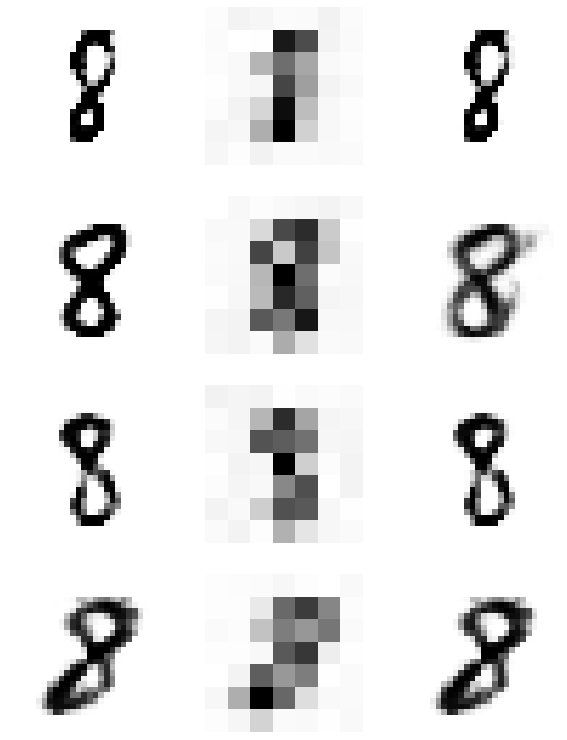

In [31]:
plt.figure(figsize=(9,12), dpi=80) #figure size

for i in range(4):
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
    #images = np.concatenate([clean_images[:,i].reshape(28,28).T,impainted_images[:,i].reshape(28,28).T, output_to_image(G(noises[i]))],axis=1)
    #plt.imshow(images,cmap='gray', vmax=images.max())
    #ax1.imshow(clean_images[:,i].reshape(28,28).T,cmap='gray')
    #ax2.imshow(impainted_images[:,i].reshape(28,28).T,cmap='gray')
    #ax3.imshow(output_to_image(G(noises[i])),cmap='gray')
    
    plt.subplot(4, 3, 1+3*i)
    plt.imshow(clean_images[:,i].reshape(28,28).T,cmap='gray')
    plt.axis('off')
    plt.subplot(4, 3, 2+3*i)
    plt.imshow(noisy_images[:,i].reshape(7,7).T,cmap='gray')
    plt.axis('off')
    plt.subplot(4, 3, 3+3*i)
    plt.imshow(output_to_image(G(noises[i])),cmap='gray')
    plt.axis('off')

    #plt.show()

$True Data$

In [32]:
from torchvision import datasets, transforms

In [33]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)

testset = datasets.MNIST('test', download=True, train=False, transform=transform)

In [34]:
idx =(trainset.targets==8)
y_train = trainset.targets[idx]
X_train = trainset.data[idx]/255

idx = (testset.targets==8)
y_test = testset.targets[idx]
X_test = testset.data[idx]/255

In [35]:
train_clean = X_train[np.random.randint(0,len(X_train),10)]

In [36]:
noises = []
images = []

for i in range(10):
    transformed_image = (1-train_clean[i].T.flatten()).detach().numpy()
    
    init_z = torch.tensor(np.random.normal(0,1,10)) #εισοδος σε τενσορ
    init_z.requires_grad = True #πανω σε αυτη θα υπολογισουμε την παραγωγο
    optimizer = torch.optim.Adam([init_z] ,lr=5e-2) #ορίζω ποιες παραμέτρους θα optimizαρει ο optimizer 
    print(f'-----image:{i+1}-----')
    for epoch in range(500):
        M = 28*15
        Xn = torch.tensor(T@transformed_image)
        loss = M*torch.log(torch.sum((torch.matmul(torch.tensor(T),G(init_z))-Xn)**2)) + torch.sum((init_z**2))

        optimizer.zero_grad()#clear previously stored gradients
        loss.backward() #calculates loss gradients wrt NN parameters
        optimizer.step() #apply an adam step
        if epoch%100 == 0:
            print(f'epoch:{epoch+1}, loss:{loss.item()}')
    noises.append(init_z)
    print('------------------- \n')
    images.append(np.concatenate([1-train_clean[i], np.pad(Xn,(0,28*13)).reshape(28,28).T,output_to_image(G(init_z))], axis=1))
images = np.concatenate(images)

-----image:1-----
epoch:1, loss:1624.0803568951553
epoch:101, loss:477.05243204610963
epoch:201, loss:475.50329025134715
epoch:301, loss:475.6764038068551
epoch:401, loss:475.63929589385066
------------------- 

-----image:2-----
epoch:1, loss:1463.3787146774298
epoch:101, loss:501.7192487571071
epoch:201, loss:500.4033814171259
epoch:301, loss:500.4033473632692
epoch:401, loss:500.4033473617912
------------------- 

-----image:3-----
epoch:1, loss:1680.2441480393777
epoch:101, loss:408.47917983137046
epoch:201, loss:405.39067193215675
epoch:301, loss:405.2913893517376
epoch:401, loss:405.4295070643274
------------------- 

-----image:4-----
epoch:1, loss:1592.883914422519
epoch:101, loss:964.8823952522108
epoch:201, loss:964.8138483681556
epoch:301, loss:964.8202170418629
epoch:401, loss:964.8902294678138
------------------- 

-----image:5-----
epoch:1, loss:1580.2939394577281
epoch:101, loss:356.24875850979663
epoch:201, loss:349.5071479559829
epoch:301, loss:349.77929044986445
epoch

(-0.5, 83.5, 279.5, -0.5)

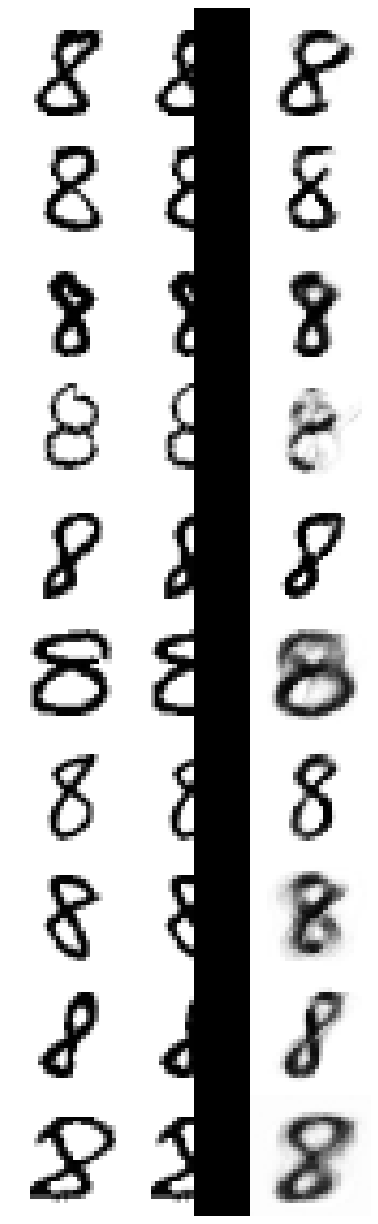

In [37]:
plt.figure(figsize=(6, 20), dpi=80)
plt.imshow(images, cmap='gray')
plt.axis('off')

In [38]:
noises = []
images = []

for i in range(10):
    transformed_image = (1-train_clean[i].T.flatten()).detach().numpy()
    
    init_z = torch.tensor(np.random.normal(0,1,10)) #εισοδος σε τενσορ
    init_z.requires_grad = True #πανω σε αυτη θα υπολογισουμε την παραγωγο
    optimizer = torch.optim.Adam([init_z] ,lr=5e-2) #ορίζω ποιες παραμέτρους θα optimizαρει ο optimizer 
    print(f'-----image:{i}-----')
    for epoch in range(500):
        M = 49
        Xn = torch.tensor(T2@transformed_image)
        loss = M*torch.log(torch.sum((torch.matmul(torch.tensor(T2),G(init_z))-Xn)**2)) + torch.sum((init_z**2))

        optimizer.zero_grad()#clear previously stored gradients
        loss.backward() #calculates loss gradients wrt NN parameters
        optimizer.step() #apply an adam step
        if epoch%100 == 0:
            print(f'epoch:{epoch+1}, loss:{loss.item()}')
    noises.append(init_z)
    print('------------------- \n')
    images.append(np.concatenate([1-train_clean[i], np.kron(Xn.reshape(7,7).T,np.ones((4,4))),output_to_image(G(init_z))], axis=1))
images = np.concatenate(images)

-----image:0-----
epoch:1, loss:22.75150672786011
epoch:101, loss:-82.35766908750817
epoch:201, loss:-82.39988330545222
epoch:301, loss:-82.36971418480306
epoch:401, loss:-82.33359683895608
------------------- 

-----image:1-----
epoch:1, loss:42.0695329001188
epoch:101, loss:-101.34909154595805
epoch:201, loss:-101.4931186420824
epoch:301, loss:-101.4770599053059
epoch:401, loss:-101.45042951415624
------------------- 

-----image:2-----
epoch:1, loss:32.446541951014076
epoch:101, loss:-161.41766917626023
epoch:201, loss:-161.8276149721609
epoch:301, loss:-161.75837899674613
epoch:401, loss:-161.81813367579306
------------------- 

-----image:3-----
epoch:1, loss:23.34108241349876
epoch:101, loss:-84.67059189508535
epoch:201, loss:-85.02315415756898
epoch:301, loss:-84.87526386619032
epoch:401, loss:-84.90807109250298
------------------- 

-----image:4-----
epoch:1, loss:57.569300137007254
epoch:101, loss:-158.50689899949174
epoch:201, loss:-158.61388290988322
epoch:301, loss:-158.603

(-0.5, 83.5, 279.5, -0.5)

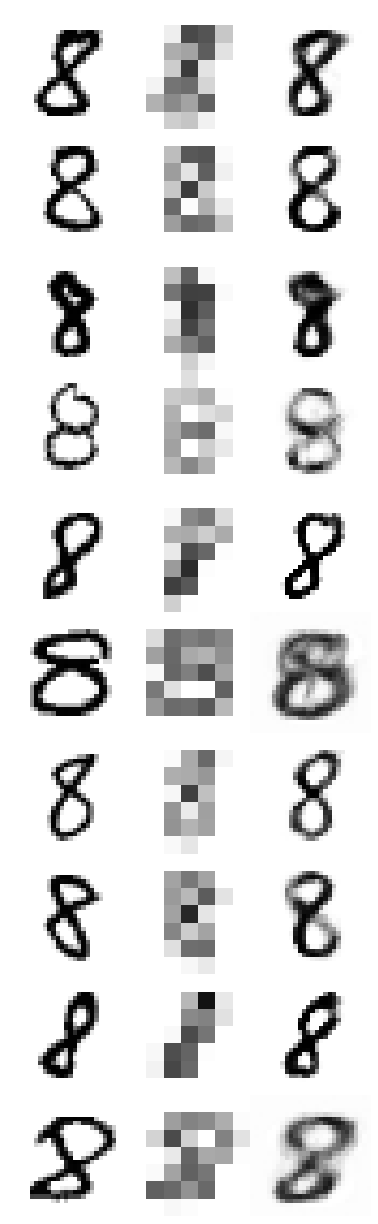

In [39]:
plt.figure(figsize=(6, 20), dpi=80)
plt.imshow(images, cmap='gray')
plt.axis('off')